In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split



In [2]:
with open("data/kernel_generated2/Pressure_s_Carbon-loc-isoth-N2.xlsx.npy", 'rb') as f:
    pressures_carbon = np.load(f)
with open("data/kernel_generated2/Pressure_s_Silica-loc-isoth1.xlsx.npy", 'rb') as f:
    pressures_silica = np.load(f)

x = []
y = []
for i in range(1, 10001):
    raw_data = np.load(f'data/test_silica/{i}.npz')
    x.append([raw_data["n_s"]/max(raw_data["n_s"]), raw_data["n_d"]/max(raw_data["n_d"])])
    y.append([1])
for i in range(1, 10001):
    raw_data = np.load(f'data/test_carbon/{i}.npz')
    n_s = np.interp(pressures_silica, pressures_carbon, raw_data["n_s"])
    n_d = np.interp(pressures_silica, pressures_carbon, raw_data["n_d"])
    x.append([n_s/max(n_s), n_d/max(n_d)])
    y.append([0])
#x, y = shuffle(x, y)
x = np.array(x)
y = np.array(y)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]
# x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
# x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [16]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(2, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=np.array(x_train).shape[1:])

In [17]:
epochs = 50
batch_size = 100

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/50
108/108 [==============================] - 3s 7ms/step - loss: 0.1436 - sparse_categorical_accuracy: 0.9424 - val_loss: 6.8398 - val_sparse_categorical_accuracy: 0.5078 - lr: 0.0010
Epoch 2/50
108/108 [==============================] - 1s 5ms/step - loss: 0.0022 - sparse_categorical_accuracy: 1.0000 - val_loss: 5.9946 - val_sparse_categorical_accuracy: 0.5078 - lr: 0.0010
Epoch 3/50
108/108 [==============================] - 1s 5ms/step - loss: 0.0013 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.9234 - val_sparse_categorical_accuracy: 0.5078 - lr: 0.0010
Epoch 4/50
108/108 [==============================] - 1s 5ms/step - loss: 9.4064e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 3.7021 - val_sparse_categorical_accuracy: 0.5078 - lr: 0.0010
Epoch 5/50
108/108 [==============================] - 1s 5ms/step - loss: 7.5043e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.4058 - val_sparse_categorical_accuracy: 0.5993 - lr: 0.0010
Epoch 6/50
108/108 [=======

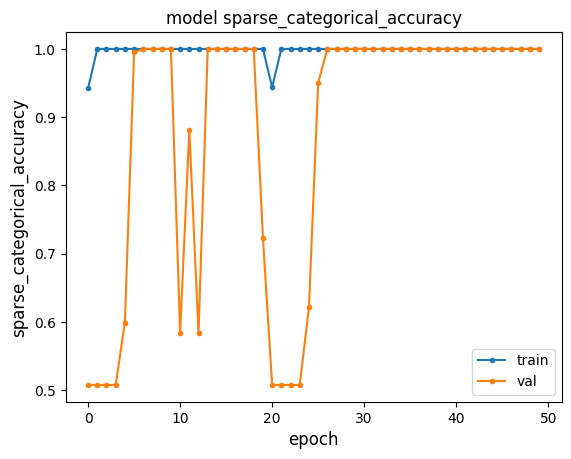

In [18]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric], marker=".")
plt.plot(history.history["val_" + metric], marker=".")
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [19]:
res = model.predict(x_test)
acc = model.evaluate(x_test, y_test)
print(acc)

207/207 [==============================] - 0s 2ms/step - loss: 6.5592e-06 - sparse_categorical_accuracy: 1.0000
[6.559237590408884e-06, 1.0]


Нейросеть: 1 с вероятностью 0.9999978542327881 
Ответ 1


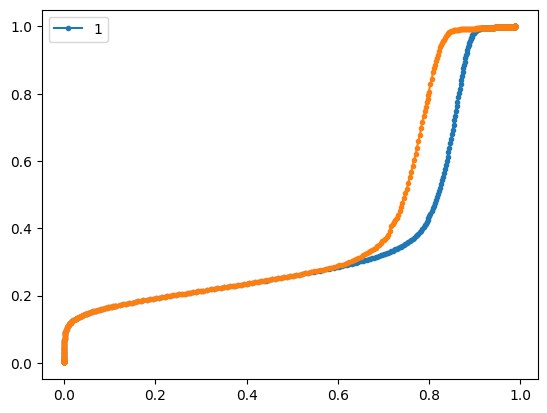

In [24]:
i = 2345
print(f"Нейросеть: {np.argmax(res[i])} с вероятностью {res[i][np.argmax(res[i])]} \nОтвет {y_test[i][0]}")
plt.plot(pressures_silica, x_test[i][0], marker=".", label=f"{y_test[i][0]}")
plt.plot(pressures_silica, x_test[i][1], marker=".")
plt.legend()
plt.show()

1/1 [==============================] - 0s 21ms/step
Нейросеть: 0 с вероятностью 0.9999924898147583


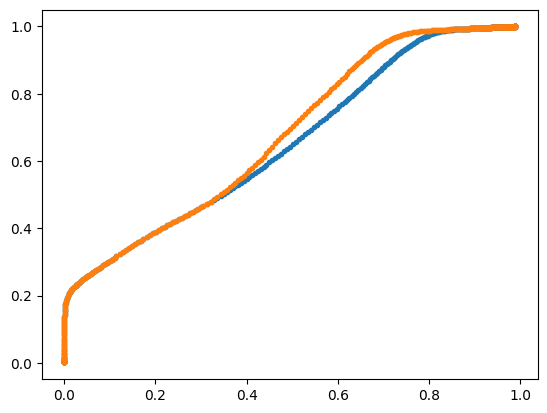

In [61]:
raw_data = np.load(f'data/test_carbon/{10}.npz')
n_s = np.interp(pressures_silica, pressures_carbon, raw_data["n_s"])
n_d = np.interp(pressures_silica, pressures_carbon, raw_data["n_d"])
n_s = n_s / max(n_s)
n_d = n_d / max(n_d)
plt.plot(pressures_silica, n_s, marker=".", label=f"{i}")
plt.plot(pressures_silica, n_d, marker=".")
result = model.predict(np.array([[n_s, n_d]]))
print(f"Нейросеть: {np.argmax(result)} с вероятностью {result[0][np.argmax(result)]}")


1/1 [==============================] - 0s 18ms/step
Нейросеть: 1 с вероятностью 0.999982476234436


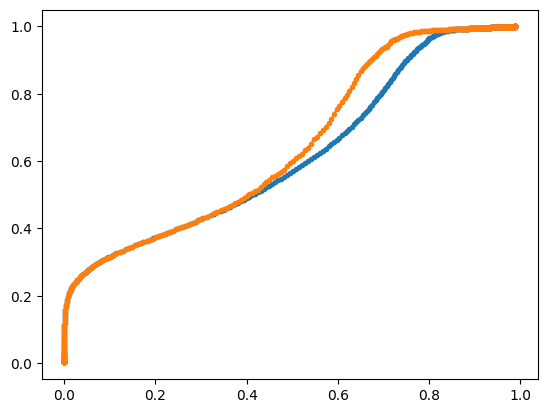

In [60]:
raw_data = np.load(f'data/test_silica/{10}.npz')
n_s = np.interp(pressures_silica, pressures_silica, raw_data["n_s"])
n_d = np.interp(pressures_silica, pressures_silica, raw_data["n_d"])
n_s = n_s / max(n_s)
n_d = n_d / max(n_d)
plt.plot(pressures_silica, n_s, marker=".", label=f"{i}")
plt.plot(pressures_silica, n_d, marker=".")
result = model.predict(np.array([[n_s, n_d]]))
print(f"Нейросеть: {np.argmax(result)} с вероятностью {result[0][np.argmax(result)]}")
